In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import jensenshannon
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

## data female

In [6]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()
df_female= df.groupby(['age','mouse']).mean()


## data males

In [7]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()
df_male= df.groupby(['age','mouse']).mean()


## normalized

In [8]:
# avarage per age or session
f_df= df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [9]:
## joint data
#m_data=m_norm.copy()
m_data=m_df.copy()
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

#f_data=f_norm.copy()
f_data=f_df.copy()
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

In [10]:
format_plots()

In [11]:
# Function to filter weeks with more than 2 measures
def filter_valid_weeks(df):
    valid_weeks = df.groupby(['mouse', 'sex', df.index.get_level_values('age') // 1]).filter(lambda x: len(x) > 3)
    return valid_weeks

df_valid = filter_valid_weeks(data)

In [12]:
# Function to calculate Euclidean distance
def calculate_euclidean(df):
    return df.groupby('mouse').apply(
        lambda x: np.mean([euclidean(x.iloc[i][3:], x.iloc[i+1][3:]) for i in range(len(x)-1)])
    ).reset_index(name='euclidean_distance')

# Function to calculate JSD
def calculate_jsd(df):
    return df.groupby('mouse').apply(
        lambda x: np.mean([jensenshannon(x.iloc[i][3:], x.iloc[i+1][3:]) for i in range(len(x)-1)])
    ).reset_index(name='jsd_distance')

# Create a week identifier
df_valid['week'] = df_valid.index.get_level_values('age') // 1

# Calculate distances
euclidean_df = df_valid.groupby(['week', 'sex']).apply(calculate_euclidean).reset_index(level=2, drop=True).reset_index()
jsd_df = df_valid.groupby(['week', 'sex']).apply(calculate_jsd).reset_index(level=2, drop=True).reset_index()


# Aggregate distances by sex with standard error of the mean
avg_euclidean_sex = euclidean_df.groupby('sex')['euclidean_distance'].agg(['mean', 'sem']).reset_index()
avg_jsd_sex = jsd_df.groupby('sex')['jsd_distance'].agg(['mean', 'sem']).reset_index()

print("Average Euclidean Distance by Sex with SEM:")
print(avg_euclidean_sex)
print("\nAverage JSD Distance by Sex with SEM:")
print(avg_jsd_sex)


/tmp/ipykernel_6307/2262886448.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  euclidean_df = df_valid.groupby(['week', 'sex']).apply(calculate_euclidean).reset_index(level=2, drop=True).reset_index()


Average Euclidean Distance by Sex with SEM:
  sex      mean       sem
0   f  0.047840  0.000635
1   m  0.052447  0.000692

Average JSD Distance by Sex with SEM:
  sex      mean       sem
0   f  0.034116  0.000911
1   m  0.036637  0.001008


/tmp/ipykernel_6307/2262886448.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  jsd_df = df_valid.groupby(['week', 'sex']).apply(calculate_jsd).reset_index(level=2, drop=True).reset_index()


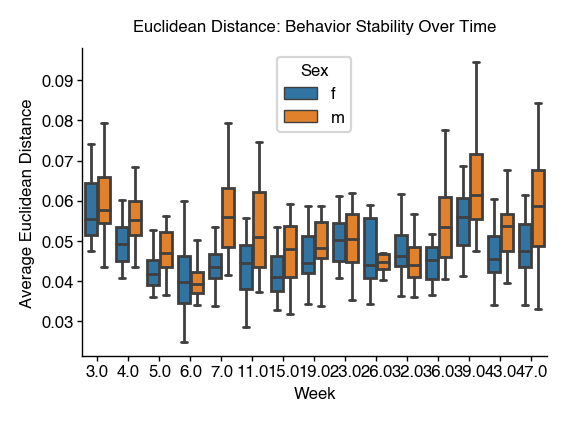

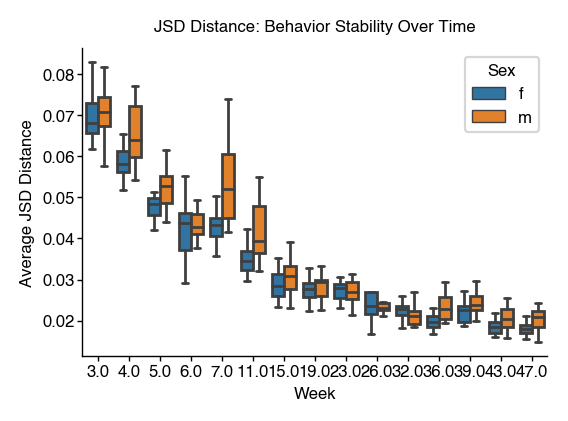

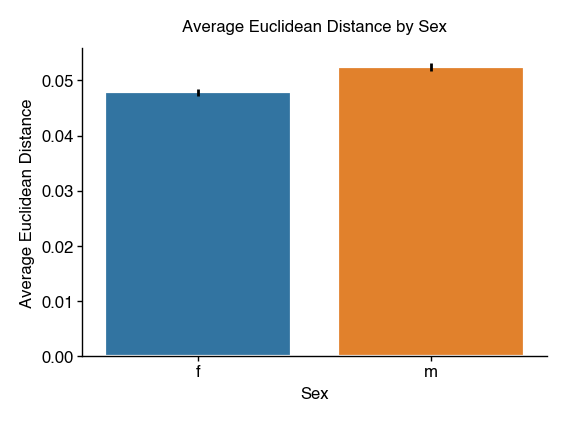

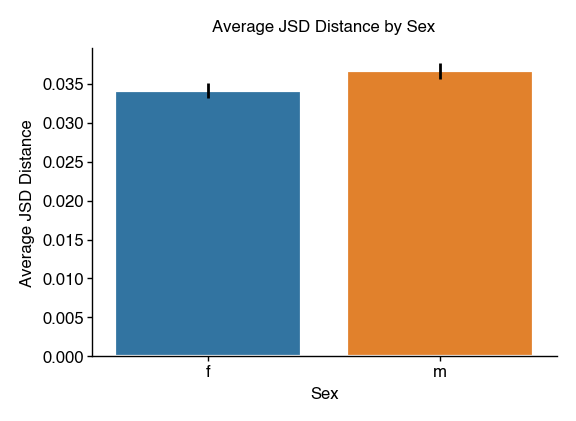

In [13]:
# Plotting Euclidean distances by week
plt.figure(figsize=(3, 2))
sns.boxplot(x='week', y='euclidean_distance', hue='sex', data=euclidean_df,showfliers=False)
plt.title('Euclidean Distance: Behavior Stability Over Time')
plt.xlabel('Week')
plt.ylabel('Average Euclidean Distance')
plt.legend(title='Sex')
sns.despine()
plt.show()

# Plotting JSD distances by week
plt.figure(figsize=(3, 2))
sns.boxplot(x='week', y='jsd_distance', hue='sex', data=jsd_df,showfliers=False)
plt.title('JSD Distance: Behavior Stability Over Time')
plt.xlabel('Week')
plt.ylabel('Average JSD Distance')
plt.legend(title='Sex')
sns.despine()
plt.show()

#Plotting average Euclidean distances by sex with error bars
plt.figure(figsize=(3, 2))
sns.barplot(x='sex', y='mean', yerr=avg_euclidean_sex['sem'], data=avg_euclidean_sex)
plt.title('Average Euclidean Distance by Sex')
plt.xlabel('Sex')
plt.ylabel('Average Euclidean Distance')
sns.despine()
plt.show()

# Plotting average JSD distances by sex with error bars
plt.figure(figsize=(3, 2))
sns.barplot(x='sex', y='mean', yerr=avg_jsd_sex['sem'], data=avg_jsd_sex)
plt.title('Average JSD Distance by Sex')
plt.xlabel('Sex')
plt.ylabel('Average JSD Distance')
sns.despine()
plt.show()


In [14]:
# second try

In [15]:
# Function to filter weeks with more than 2 measures
def filter_valid_weeks(df):
    # Create a week identifier
    df = df.reset_index()
    df['week'] = df['age'].astype(float) // 1
    
    # Filter weeks with more than 2 measures
    valid_weeks = df.groupby(['mouse', 'sex', 'week']).filter(lambda x: len(x) > 2)
    return valid_weeks.set_index(['mouse', 'age', 'sex'])

df_valid = filter_valid_weeks(data)

In [16]:
df_valid.index.get_level_values('age').unique()

Index([3.4285714626312256, 3.5714285373687744, 3.7142856121063232,
        3.857142925262451,                4.0, 4.4285712242126465,
       4.5714287757873535,  4.714285850524902,  4.857142925262451,
                      5.0, 5.4285712242126465, 5.5714287757873535,
        5.714285850524902,  5.857142925262451,                6.0,
       6.4285712242126465, 6.5714287757873535,  6.714285850524902,
        6.857142925262451,                7.0, 7.4285712242126465,
       7.5714287757873535,  7.714285850524902,  7.857142925262451,
                      9.0,  9.571428298950195,  9.857142448425293,
       11.428571701049805, 11.571428298950195, 11.714285850524902,
       11.857142448425293, 15.142857551574707, 15.285714149475098,
       15.428571701049805, 15.571428298950195, 15.714285850524902,
       15.857142448425293, 19.428571701049805, 19.571428298950195,
       19.714284896850586,  19.85714340209961, 23.428571701049805,
       23.571428298950195, 23.714284896850586,  23.85714340209

In [17]:
# Function to calculate Euclidean distance
def calculate_euclidean(df):
    return df.groupby(level='mouse').apply(
        lambda x: np.mean([euclidean(x.iloc[i], x.iloc[i+1]) for i in range(len(x)-1)])
    ).reset_index(name='euclidean_distance')

# Function to calculate JSD
def calculate_jsd(df):
    return df.groupby(level='mouse').apply(
        lambda x: np.mean([jensenshannon(x.iloc[i], x.iloc[i+1]) for i in range(len(x)-1)])
    ).reset_index(name='jsd_distance')

# Calculate distances
euclidean_df = df_valid.groupby(['week', 'sex']).apply(calculate_euclidean).reset_index(level=2, drop=True).reset_index()
jsd_df = df_valid.groupby(['week', 'sex']).apply(calculate_jsd).reset_index(level=2, drop=True).reset_index()


/tmp/ipykernel_6307/1081679576.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  euclidean_df = df_valid.groupby(['week', 'sex']).apply(calculate_euclidean).reset_index(level=2, drop=True).reset_index()
/tmp/ipykernel_6307/1081679576.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  jsd_df = df_valid.groupby(['week', 'sex']).apply(calculate_jsd).reset_index(level=2, drop=True).reset_index()


In [18]:
# Aggregate distances by sex with standard error of the mean
avg_euclidean_sex = euclidean_df.groupby('sex')['euclidean_distance'].agg(['mean', 'sem']).reset_index()
avg_jsd_sex = jsd_df.groupby('sex')['jsd_distance'].agg(['mean', 'sem']).reset_index()

print("Average Euclidean Distance by Sex with SEM:")
print(avg_euclidean_sex)
print("\nAverage JSD Distance by Sex with SEM:")
print(avg_jsd_sex)


Average Euclidean Distance by Sex with SEM:
  sex      mean       sem
0   f  0.051234  0.000908
1   m  0.053301  0.000691

Average JSD Distance by Sex with SEM:
  sex      mean       sem
0   f  0.034106  0.000779
1   m  0.035633  0.000843


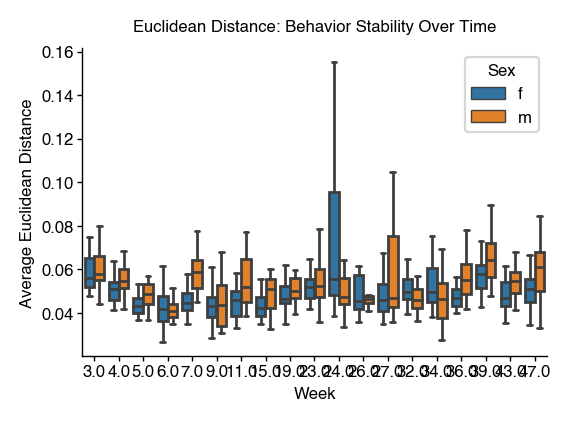

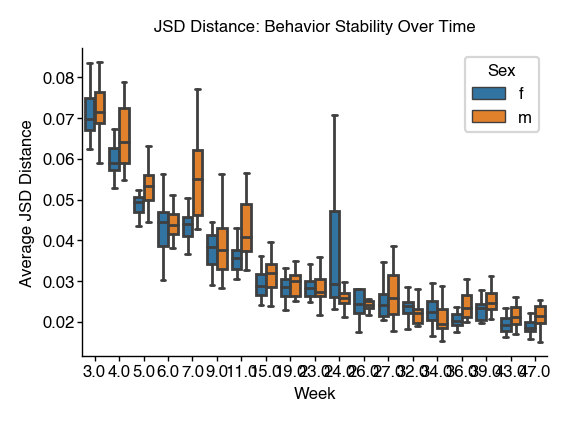

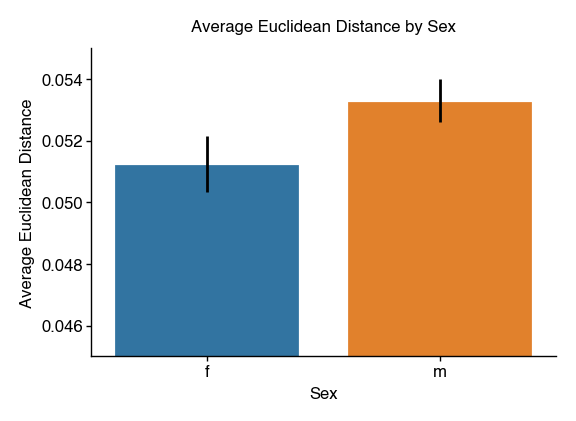

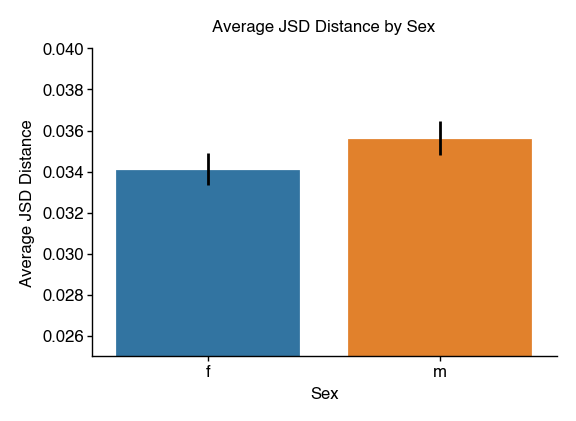

In [19]:
# Plotting Euclidean distances by week without outliers
plt.figure(figsize=(3, 2))
sns.boxplot(x='week', y='euclidean_distance', hue='sex', data=euclidean_df, showfliers=False)
plt.title('Euclidean Distance: Behavior Stability Over Time')
plt.xlabel('Week')
plt.ylabel('Average Euclidean Distance')
plt.legend(title='Sex')
sns.despine()
plt.show()

# Plotting JSD distances by week without outliers
plt.figure(figsize=(3, 2))
sns.boxplot(x='week', y='jsd_distance', hue='sex', data=jsd_df, showfliers=False)
plt.title('JSD Distance: Behavior Stability Over Time')
plt.xlabel('Week')
plt.ylabel('Average JSD Distance')
plt.legend(title='Sex')
sns.despine()
plt.show()

# Plotting average Euclidean distances by sex with error bars
plt.figure(figsize=(3, 2))
sns.barplot(x='sex', y='mean', yerr=avg_euclidean_sex['sem'], data=avg_euclidean_sex)
plt.title('Average Euclidean Distance by Sex')
plt.xlabel('Sex')
plt.ylabel('Average Euclidean Distance')
plt.ylim([0.045,0.055])
sns.despine()
plt.show()

# Plotting average JSD distances by sex with error bars
plt.figure(figsize=(3, 2))
sns.barplot(x='sex', y='mean', yerr=avg_jsd_sex['sem'], data=avg_jsd_sex)
plt.title('Average JSD Distance by Sex')
plt.xlabel('Sex')
plt.ylabel('Average JSD Distance')
plt.ylim([0.025,0.040])
sns.despine()
plt.show()


In [20]:
# all pairwise options

In [21]:
# Function to filter weeks with more than 2 measures
def filter_valid_weeks(df):
    # Create a week identifier
    df = df.reset_index()
    df['week'] = df['age'].astype(float) // 1
    
    # Filter weeks with more than 2 measures
    valid_weeks = df.groupby(['mouse', 'sex', 'week']).filter(lambda x: len(x) > 2)
    return valid_weeks.set_index(['mouse', 'age', 'sex'])

df_valid = filter_valid_weeks(data)


In [22]:
# Function to calculate pairwise Euclidean distance
def calculate_pairwise_euclidean(df):
    return df.groupby(level='mouse').apply(
        lambda x: np.mean([euclidean(x.iloc[i], x.iloc[j]) for i in range(len(x)) for j in range(i+1, len(x))])
    ).reset_index(name='euclidean_distance')

# Function to calculate pairwise JSD distance
def calculate_pairwise_jsd(df):
    return df.groupby(level='mouse').apply(
        lambda x: np.mean([jensenshannon(x.iloc[i], x.iloc[j]) for i in range(len(x)) for j in range(i+1, len(x))])
    ).reset_index(name='jsd_distance')

# Calculate distances
euclidean_df = df_valid.groupby(['week', 'sex']).apply(calculate_pairwise_euclidean).reset_index(level=2, drop=True).reset_index()
jsd_df = df_valid.groupby(['week', 'sex']).apply(calculate_pairwise_jsd).reset_index(level=2, drop=True).reset_index()


/tmp/ipykernel_6307/954135750.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  euclidean_df = df_valid.groupby(['week', 'sex']).apply(calculate_pairwise_euclidean).reset_index(level=2, drop=True).reset_index()
/tmp/ipykernel_6307/954135750.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  jsd_df = df_valid.groupby(['week', 'sex']).apply(calculate_pairwise_jsd).reset_index(level=2, drop=True).reset_in

In [23]:
# Aggregate distances by sex with standard error of the mean
avg_euclidean_sex = euclidean_df.groupby('sex')['euclidean_distance'].agg(['mean', 'sem']).reset_index()
avg_jsd_sex = jsd_df.groupby('sex')['jsd_distance'].agg(['mean', 'sem']).reset_index()

print("Average Euclidean Distance by Sex with SEM:")
print(avg_euclidean_sex)
print("\nAverage JSD Distance by Sex with SEM:")
print(avg_jsd_sex)


Average Euclidean Distance by Sex with SEM:
  sex      mean       sem
0   f  0.054829  0.000774
1   m  0.056801  0.000702

Average JSD Distance by Sex with SEM:
  sex      mean       sem
0   f  0.036533  0.000866
1   m  0.037755  0.000921


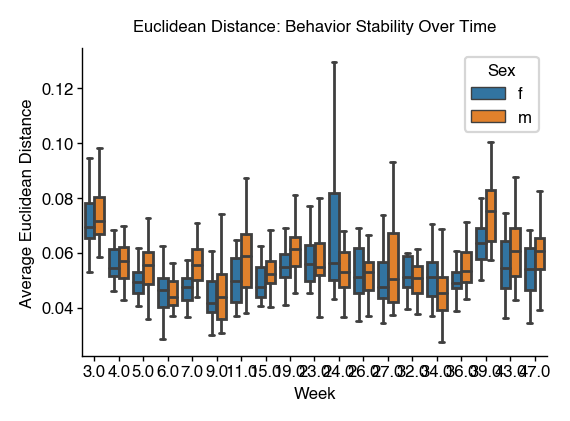

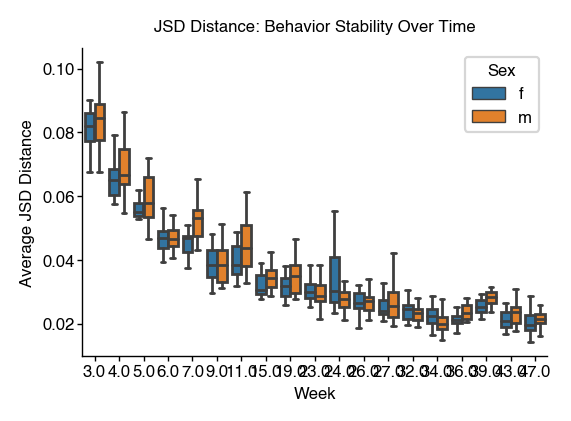

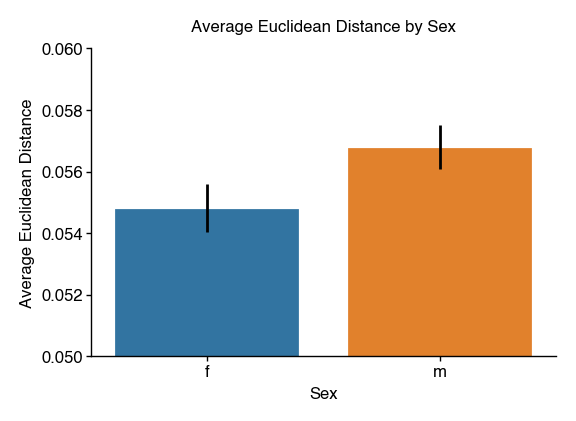

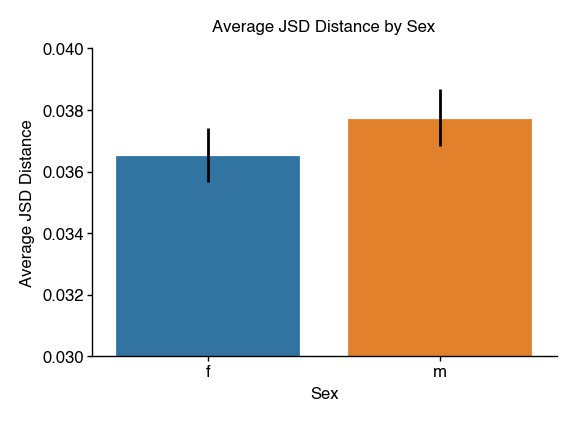

In [27]:
# Plotting Euclidean distances by week without outliers
plt.figure(figsize=(3, 2))
sns.boxplot(x='week', y='euclidean_distance', hue='sex', data=euclidean_df, showfliers=False)
plt.title('Euclidean Distance: Behavior Stability Over Time')
plt.xlabel('Week')
plt.ylabel('Average Euclidean Distance')
plt.legend(title='Sex')
sns.despine()
plt.show()

# Plotting JSD distances by week without outliers
plt.figure(figsize=(3, 2))
sns.boxplot(x='week', y='jsd_distance', hue='sex', data=jsd_df, showfliers=False)
plt.title('JSD Distance: Behavior Stability Over Time')
plt.xlabel('Week')
plt.ylabel('Average JSD Distance')
plt.legend(title='Sex')
sns.despine()
plt.show()

# Plotting average Euclidean distances by sex with error bars
plt.figure(figsize=(3, 2))
sns.barplot(x='sex', y='mean', yerr=avg_euclidean_sex['sem'], data=avg_euclidean_sex)
plt.title('Average Euclidean Distance by Sex')
plt.xlabel('Sex')
plt.ylabel('Average Euclidean Distance')
plt.ylim([0.050,0.060])
sns.despine()
plt.show()

# Plotting average JSD distances by sex with error bars
plt.figure(figsize=(3, 2))
sns.barplot(x='sex', y='mean', yerr=avg_jsd_sex['sem'], data=avg_jsd_sex)
plt.title('Average JSD Distance by Sex')
plt.xlabel('Sex')
plt.ylabel('Average JSD Distance')
plt.ylim([0.030,0.040])
sns.despine()
plt.show()
